In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [11]:
!kaggle datasets download -d uciml/default-of-credit-card-clients-dataset

Dataset URL: https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset
License(s): CC0-1.0
default-of-credit-card-clients-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [14]:
import zipfile
zipref=zipfile.ZipFile('/content/default-of-credit-card-clients-dataset.zip','r')
zipref.extractall('/content')
zipref.close()

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import gc
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
!pip install catboost
!pip install xgboost
import catboost
from catboost import CatBoostClassifier
!pip install lightgbm
import lightgbm as lgb

pd.set_option('display.max_columns', 100)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.5 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 4.9 MB/s eta 0:00:00


## Set parameters

Here we set few parameters for the analysis and models.

In [15]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False

import os

if(IS_LOCAL):
    PATH="/content/default-of-credit-card-clients-dataset"
else:
    PATH="/content/"
print(os.listdir(PATH))

['.config', 'UCI_Credit_Card.csv', 'kaggle.json', 'default-of-credit-card-clients-dataset.zip', '.ipynb_checkpoints', 'sample_data']


# Reviewing the data

In [23]:
import pandas as pd

In [24]:
data_df = pd.read_csv(PATH+"/UCI_Credit_Card.csv")


In [17]:
print("Default Credit Card Clients data -  rows:",data_df.shape[0]," columns:", data_df.shape[1])

Default Credit Card Clients data -  rows: 30000  columns: 25


In [19]:
data_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [20]:
data_df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


There are 30,000 distinct credit card clients.

The average value for the amount of credit card limit is around 167,484. The standard deviation is unusually large, max value being 1M(1000000).

Education level is mostly graduate school and university.

Most of the clients are either marrined or single (less frequent the other status).

Average age is 35.5 years, with a standard deviation of 9.2.

As the value 0 for default payment means 'not default' and value 1 means 'default', the mean of 0.221 means that there are 22.1% of credit card contracts that will default next month (will verify this in the next sections of this analysis).

#Analysing the data

In [21]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,ID,BILL_AMT2,PAY_AMT6,PAY_AMT5,PAY_AMT4,PAY_AMT3,PAY_AMT2,PAY_AMT1,BILL_AMT6,BILL_AMT5,BILL_AMT4,BILL_AMT3,BILL_AMT1,LIMIT_BAL,PAY_6,PAY_5,PAY_4,PAY_3,PAY_2,PAY_0,AGE,MARRIAGE,EDUCATION,SEX,default.payment.next.month
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


No missing data found

In [31]:
!pip install seaborn

Let's check data unbalance with respect with target value, i.e. default.payment.next.month.

In [32]:
import seaborn as sns

6636 22.12 %


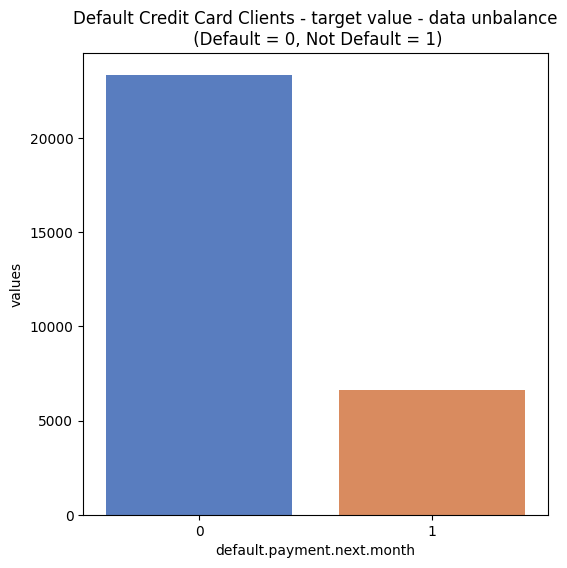

In [84]:
temp = data_df["default.payment.next.month"].value_counts()
total_clients = data_df.shape[0]
default_clients = (data_df["default.payment.next.month"] == 1).sum()
num_defaults = (data_df["default.payment.next.month"] == 1).sum()
default_percentage = (default_clients / total_clients) * 100

print(num_defaults, default_percentage,'%')
df = pd.DataFrame({'default.payment.next.month': temp.index,'values': temp.values})
plt.figure(figsize = (6,6))
plt.title('Default Credit Card Clients - target value - data unbalance\n (Default = 0, Not Default = 1)')
sns.barplot(x='default.payment.next.month', y="values", hue='default.payment.next.month', data=df, palette='muted', legend=False)
locs, labels = plt.xticks()
plt.show()

A number of 6,636 out of 30,000 (or 22%) of clients will default next month. The data has not a large unbalance with respect of the target value (default.payment.next.month).

#Amount of credit limit

<ipython-input-78-b1162a88be29>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_df['LIMIT_BAL'],kde=True,bins=200, color="blue")


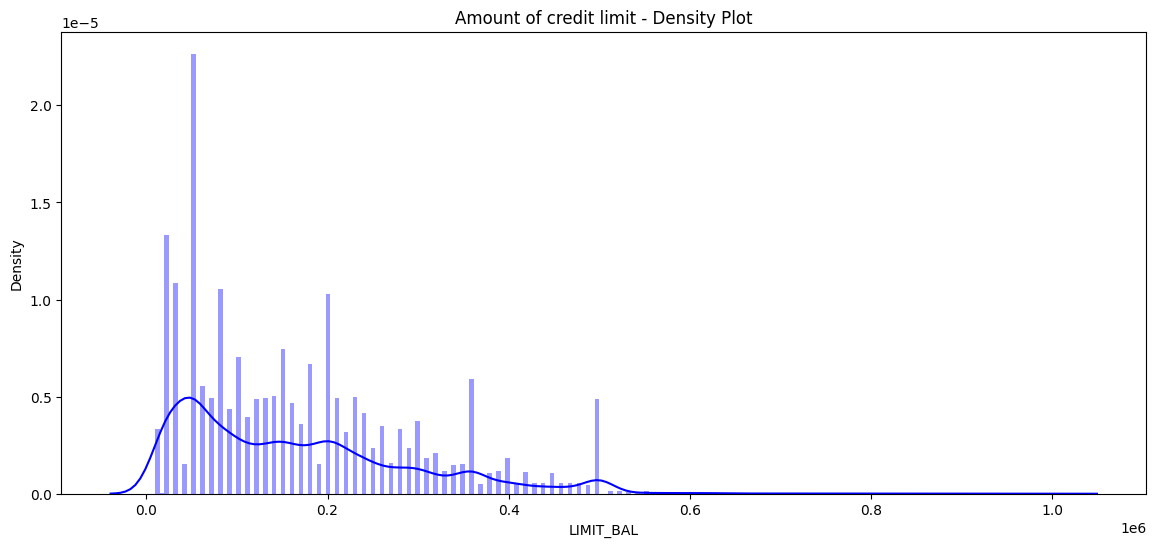

In [78]:
plt.figure(figsize = (14,6))
plt.title('Amount of credit limit - Density Plot')
sns.set_color_codes("pastel")
sns.distplot(data_df['LIMIT_BAL'],kde=True,bins=200, color="blue")
plt.show()

Largest group of amount of credit limit is apparently for amount of 50K. Let's verify this.

In [76]:
data_df['LIMIT_BAL'].value_counts().shape

(81,)

Thus there are 81 distinct values for amount fo credit limit

In [77]:
data_df['LIMIT_BAL'].value_counts().head(5)

,count
LIMIT_BAL,
50000.0,3365
20000.0,1976
30000.0,1610
80000.0,1567
200000.0,1528


Indeed, the largest number of credit cards are with limit of 50,000 (3365), followed by 20,000 (1976) and 30,000 (1610).

## Amount of credit limit grouped by default payment next month

Let's visualize the density plot for amount of credit limit (LIMIT_BAL), grouped by default payment next month.

<ipython-input-94-89b388edc43b>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(class_1,kde=True,bins=200, color="red")
<ipython-input-94-89b388edc43b>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(class_0,kde=True,bins=200, color="green")


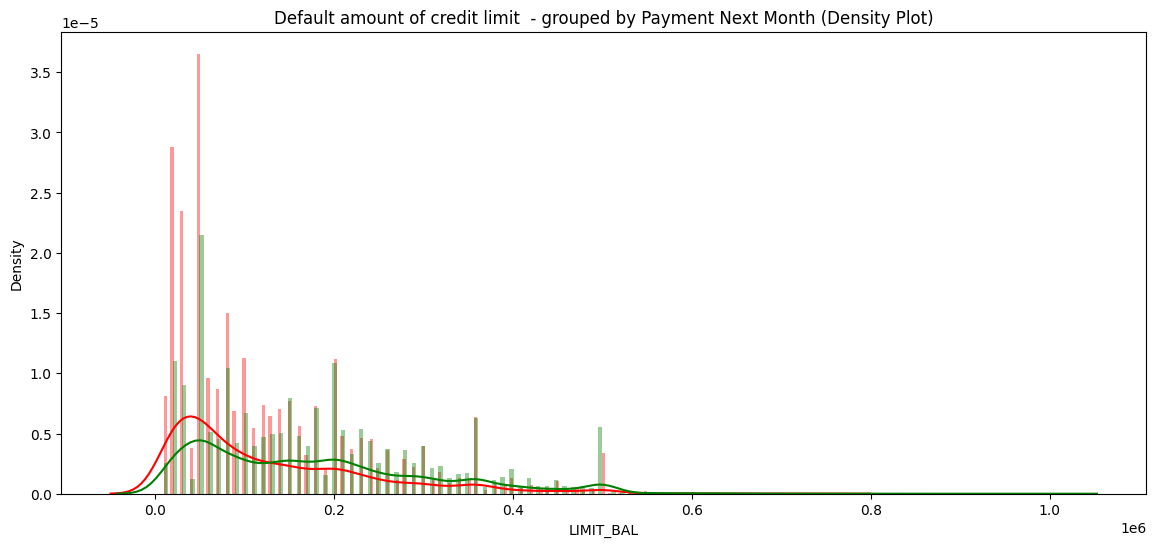

In [94]:
class_0 = data_df.loc[data_df['default.payment.next.month'] == 0]["LIMIT_BAL"]
class_1 = data_df.loc[data_df['default.payment.next.month'] == 1]["LIMIT_BAL"]
plt.figure(figsize = (14,6))
plt.title('Default amount of credit limit  - grouped by Payment Next Month (Density Plot)')
sns.set_color_codes("pastel")
sns.distplot(class_1,kde=True,bins=200, color="red")
sns.distplot(class_0,kde=True,bins=200, color="green")
plt.show()

Most of defaults are for credit limits 0-100,000 (and density for this interval is larger for defaults than for non-defaults). Larger defaults number are for the amounts of **50,000**, **20,000** and **30,000**.

##Credit Limit vs sex
Let's check the credit limit distribution vs. sex. For the sex, 1 stands for male and 2 for female.



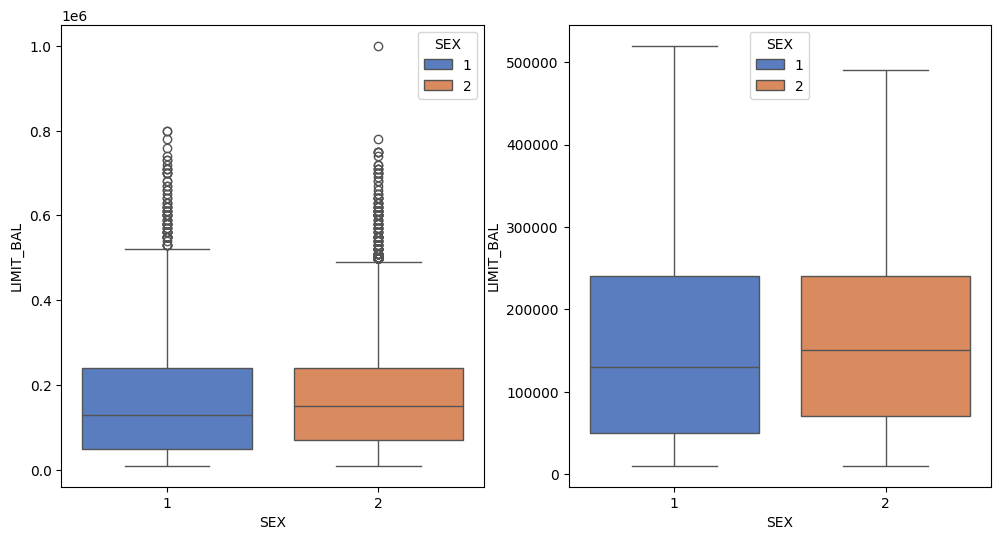

In [103]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="SEX", y="LIMIT_BAL", hue="SEX",data=data_df, palette="muted",showfliers=True)
s = sns.boxplot(ax = ax2, x="SEX", y="LIMIT_BAL", hue="SEX",data=data_df, palette="muted",showfliers=False)
plt.show();

The limit credit amount is quite balanced between sexes. The males have a slightly smaller Q2 and larger Q3 and Q4 and a lower mean. The female have a larger outlier max value (1M NT dollars).

##Features correlation

For the numeric values, let's represent the features correlation.


Let's check the correlation of Amount of bill statement in April - September 2005.

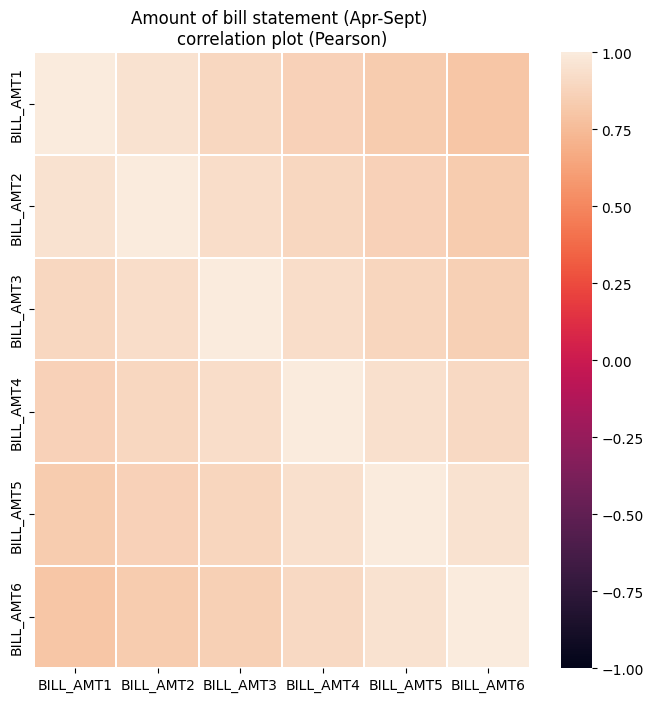

In [104]:
var = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']

plt.figure(figsize = (8,8))
plt.title('Amount of bill statement (Apr-Sept) \ncorrelation plot (Pearson)')
corr = data_df[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1)
plt.show()

Correlation is decreasing with distance between months. Lowest correlations are between Sept-April.


Let's check the correlation of Amount of previous payment in April - September 2005.

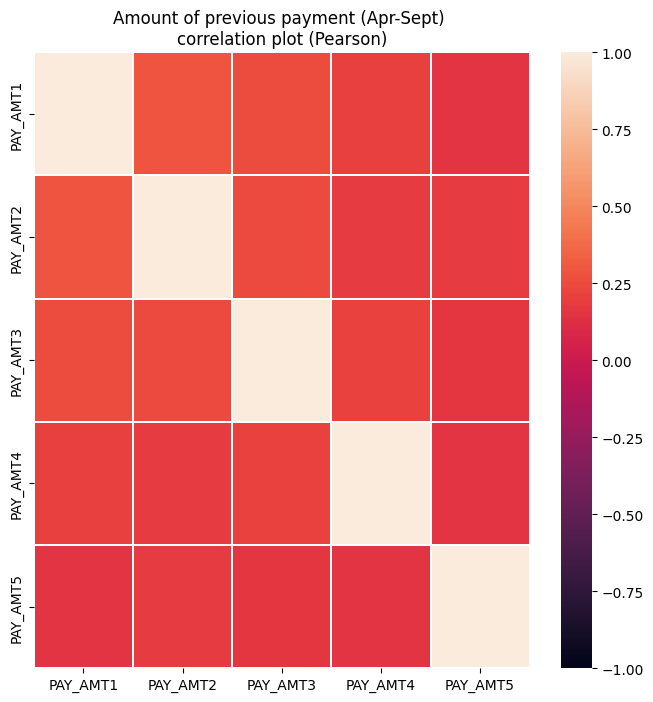

In [105]:
var = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5']

plt.figure(figsize = (8,8))
plt.title('Amount of previous payment (Apr-Sept) \ncorrelation plot (Pearson)')
corr = data_df[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1)
plt.show()

There are no correlations between amounts of previous payments for April-Sept 2005.

Let's check the correlation between Repayment status in April - September 2005.

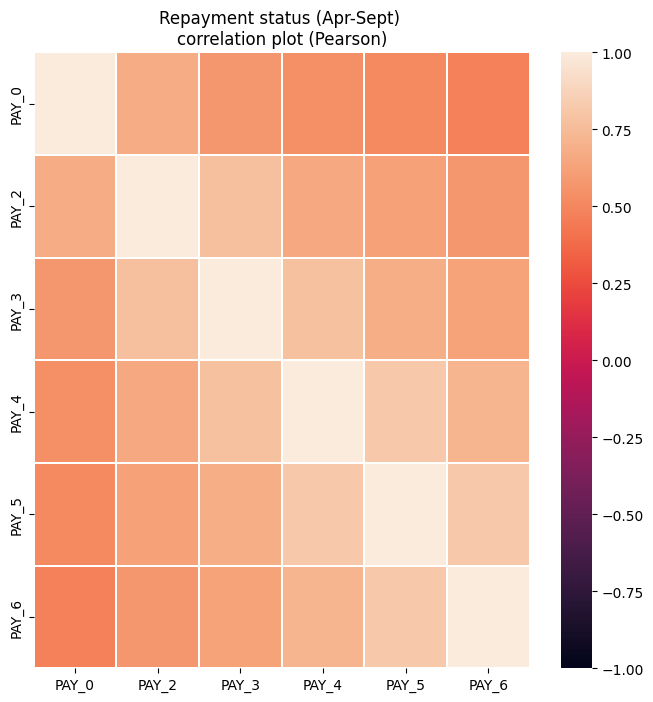

In [106]:
var = ['PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

plt.figure(figsize = (8,8))
plt.title('Repayment status (Apr-Sept) \ncorrelation plot (Pearson)')
corr = data_df[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1)
plt.show()


Correlation is decreasing with distance between months. Lowest correlations are between Sept-April.


##Sex, Education, Age and Marriage

Let's show sex, education, age and marriage distributions.

We start by showing the boxplots with age distribution grouped by marriage status and sex.

Marriage status meaning is:

* 0 : unknown (let's consider as others as well)
* 1 : married
* 2 : single
* 3 : others

Sex meaning is:

* 1 : male
* 2 : female


In [110]:
def boxplot_variation(feature1, feature2, feature3, width=16):
    fig, ax1 = plt.subplots(ncols=1, figsize=(width,6))
    s = sns.boxplot(ax = ax1, x=feature1, y=feature2, hue=feature3,
                data=data_df, palette="muted",showfliers=False)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show();

<ipython-input-110-eaf12fa2925e>:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


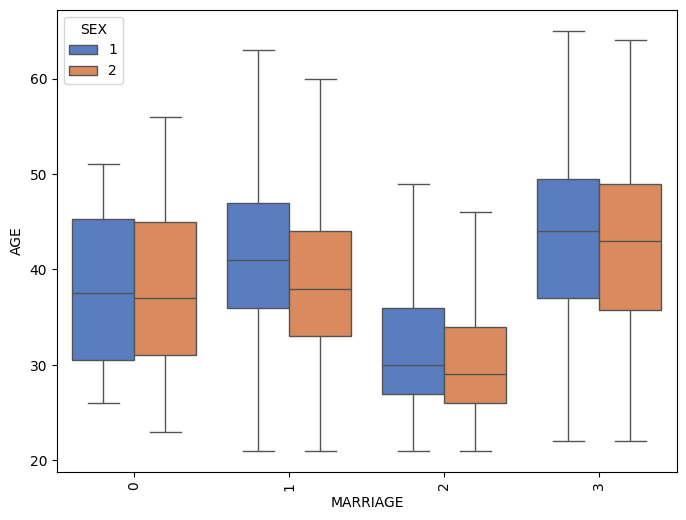

In [111]:
boxplot_variation('MARRIAGE','AGE', 'SEX',8)

It looks like Married status 3 (others), with mean values over 40 and Q4 values over 60 means mostly vidowed or divorced whilst Married status 0 could be not specified or divorced, as Q1 values are above values for married of both sexes.

Married males have mean age above married women. Unmarried males have mean value for age above unmarried women as well but closer. Q3 abd Q4 values for married man are above corresponding values for married women.


Let's show the boxplots with age distribution grouped by education and marriage.

Education status meaning is:

* 1 : graduate school
* 2 : university
* 3 : high school
* 4 : others
* 5 : unknown
* 6 : unknow


<ipython-input-110-eaf12fa2925e>:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


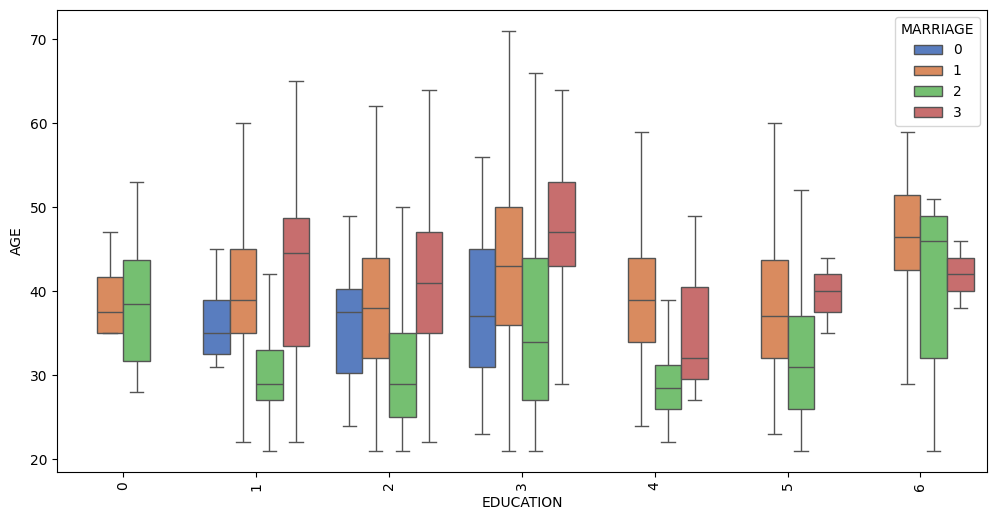

In [112]:
boxplot_variation('EDUCATION','AGE', 'MARRIAGE',12)

##Age, sex and credit amount limit
Let's show the  boxplots with credit amount limit distribution grouped by age and sex.


<ipython-input-110-eaf12fa2925e>:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


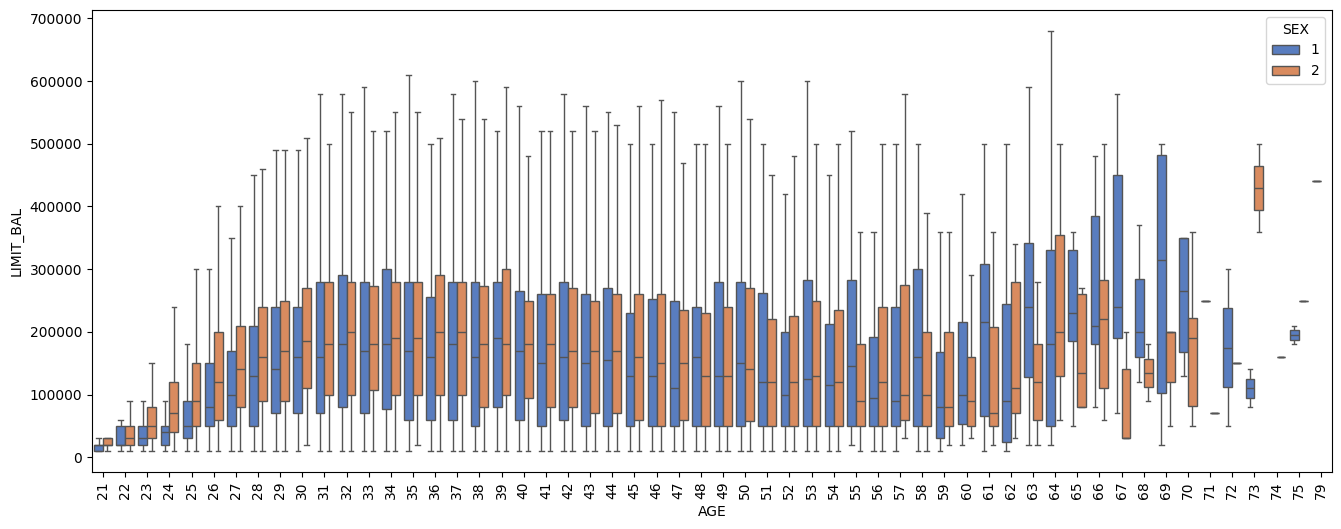

In [113]:
boxplot_variation('AGE','LIMIT_BAL', 'SEX',16)

Mean, Q3 and Q4 values are increasing for both male and female with age until aroung 35 years and then they are oscilating and get to a maximum of Q4 for males at age 64.

Mean values are generally smaller for males than for females, with few exceptions, for example at age 39, 48, until approximately 60, where mean values for males are generally larger than for females.



## Marriage status, education level and credit amount limit


Let's show the  boxplots with credit amount limit distribution grouped by marriage status and education level.

<ipython-input-110-eaf12fa2925e>:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


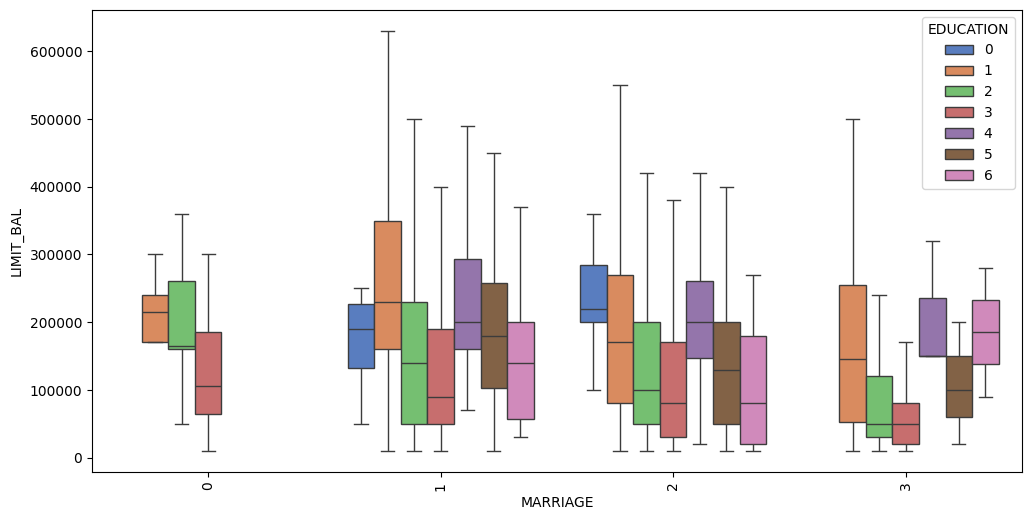

In [114]:
boxplot_variation('MARRIAGE','LIMIT_BAL', 'EDUCATION',12)

## Predictive Models



### Define predictors and target values

Let's define the predictor features and the target features. Categorical features, if any, are also defined. In our case, there are no categorical feature.

In [116]:
target = 'default.payment.next.month'
predictors = [  'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
                'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                'BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

### Split data in train and validation set

Let's define train and validation sets.

In [117]:
train_df, val_df = train_test_split(data_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

We also make copies of the train_df and val_df for later usage.

In [118]:
train_df_bkp = train_df.copy()
val_df_bkp = val_df.copy()


Let's start with a RandomForrestClassifier <a href='#8'>[3]</a>   model.

#Random Forest Classifier

Let's run a model using the training set for training. Then, we will use the validation set for validation.

### Metric

We will use as validation criterion **GINI**, which formula is **GINI = 2 * (AUC) - 1**, where **AUC** is the **Receiver Operating Characteristic - Area Under Curve (ROC-AUC)** <a href='#8'>[4]</a>.  Number of estimators is set to **100** and number of parallel jobs is set to **4**.

We start by initializing the RandomForestClassifier.

In [119]:
clf = RandomForestClassifier(n_jobs=NO_JOBS,
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

Let's train the **RandonForestClassifier** using the **train_df** data and **fit** function.

In [120]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

Let's now predict the **target** values for the **val_df** data, using **predict** function.

In [121]:
preds = clf.predict(val_df[predictors])

Let's also visualize the features importance.
### Features importance


<ipython-input-122-34030293d53b>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


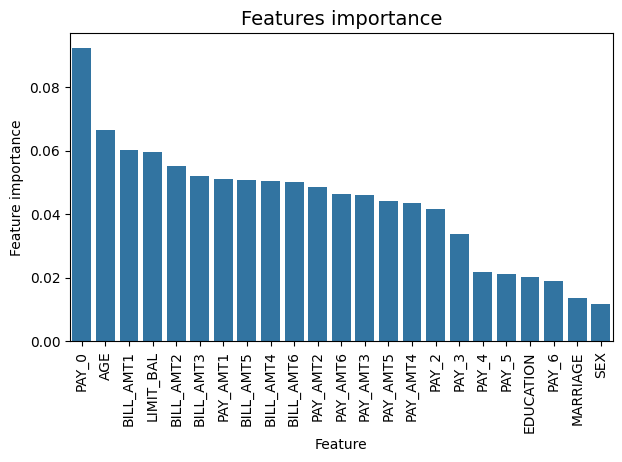

In [122]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()


The most important features are **PAY_0**, **AGE**, **BILL_AMT1**, **LIMIT_BAL**, **BILL_AMT2**, **BILL_AMT3**.


### Confusion matrix

Let's show a confusion matrix for the results we obtained.

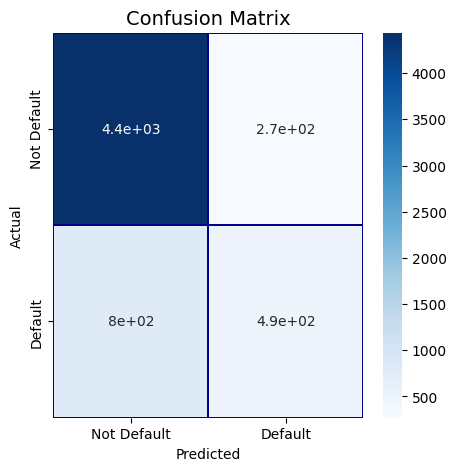

In [123]:
cm = pd.crosstab(val_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Not Default', 'Default'],
            yticklabels=['Not Default', 'Default'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

We also calculate area under curve (receiver operator characteristic).

In [124]:
roc_auc_score(val_df[target].values, preds)


0.6625018741566295

The **ROC-AUC** score obtained with **RandomForrestClassifier** is **0.66**.


Let's use for RandomForrestClassifier **dummified variables** for the **categorical features**.


We start by defining the categorical features.


### RandomForrest with OneHotEncoder

In [125]:
cat_features = ['EDUCATION', 'SEX', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [126]:
train_f_df = pd.get_dummies(train_df_bkp, columns = cat_features)
val_f_df = pd.get_dummies(val_df_bkp, columns = cat_features)

In [127]:
print("Default of Credit Card Clients train data -  rows:",train_f_df.shape[0]," columns:", train_f_df.shape[1])
print("Default of Credit Card Clients val  data -  rows:",val_f_df.shape[0]," columns:", val_f_df.shape[1])

Default of Credit Card Clients train data -  rows: 24000  columns: 93
Default of Credit Card Clients val  data -  rows: 6000  columns: 86


Because train and validation data does not have the same number of columns, we will align them.

In [128]:
train_fa_df, val_fa_df = train_f_df.align(val_f_df, join='outer', axis=1, fill_value=0)

Lets check data again

In [129]:
print("Default of Credit Card Clients train data -  rows:",train_fa_df.shape[0]," columns:", train_fa_df.shape[1])
print("Default of Credit Card Clients val  data -  rows:",val_fa_df.shape[0]," columns:", val_fa_df.shape[1])

Default of Credit Card Clients train data -  rows: 24000  columns: 93
Default of Credit Card Clients val  data -  rows: 6000  columns: 93


In [130]:
train_fa_df.head(5)

,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,ID,LIMIT_BAL,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-1,PAY_0_-2,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-1,PAY_2_-2,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-1,PAY_3_-2,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-1,PAY_4_-2,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-1,PAY_5_-2,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-1,PAY_6_-2,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,default.payment.next.month
22659,48,175095.0,175522.0,173918.0,174074.0,178671.0,178869.0,False,False,False,True,False,False,False,22660,150000.0,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,10011.0,6200.0,5874.0,10000.0,6054.0,7108.0,False,True,0
6618,37,8788.0,40927.0,28306.0,31578.0,21195.0,11776.0,False,False,True,False,False,False,False,6619,180000.0,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,40970.0,1210.0,10015.0,10009.0,11783.0,110306.0,True,False,0
26605,23,2400.0,2400.0,2400.0,2400.0,2400.0,1800.0,False,False,True,False,False,False,False,26606,20000.0,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,0.0,0.0,0.0,0.0,0.0,0.0,True,False,1
2504,30,440.0,30404.0,0.0,880.0,150.0,430.0,False,False,True,False,False,False,False,2505,180000.0,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,30404.0,0.0,880.0,150.0,430.0,747.0,True,False,0
1111,44,3424.0,155.0,1922.0,1473.0,1865.0,835.0,False,False,False,True,False,False,False,1112,50000.0,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,155.0,1922.0,1473.0,1865.0,835.0,1833.0,False,True,0


In [131]:
train_fa_df.head(5)

,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,ID,LIMIT_BAL,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-1,PAY_0_-2,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-1,PAY_2_-2,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-1,PAY_3_-2,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-1,PAY_4_-2,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-1,PAY_5_-2,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-1,PAY_6_-2,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,default.payment.next.month
22659,48,175095.0,175522.0,173918.0,174074.0,178671.0,178869.0,False,False,False,True,False,False,False,22660,150000.0,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,10011.0,6200.0,5874.0,10000.0,6054.0,7108.0,False,True,0
6618,37,8788.0,40927.0,28306.0,31578.0,21195.0,11776.0,False,False,True,False,False,False,False,6619,180000.0,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,40970.0,1210.0,10015.0,10009.0,11783.0,110306.0,True,False,0
26605,23,2400.0,2400.0,2400.0,2400.0,2400.0,1800.0,False,False,True,False,False,False,False,26606,20000.0,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,0.0,0.0,0.0,0.0,0.0,0.0,True,False,1
2504,30,440.0,30404.0,0.0,880.0,150.0,430.0,False,False,True,False,False,False,False,2505,180000.0,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,30404.0,0.0,880.0,150.0,430.0,747.0,True,False,0
1111,44,3424.0,155.0,1922.0,1473.0,1865.0,835.0,False,False,False,True,False,False,False,1112,50000.0,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,155.0,1922.0,1473.0,1865.0,835.0,1833.0,False,True,0


Let's define the target and predictors lists.

In [132]:
target_f = 'default.payment.next.month'
predictors_f = ['AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'EDUCATION_0', 'EDUCATION_1',
       'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'EDUCATION_5',
       'EDUCATION_6', 'LIMIT_BAL', 'MARRIAGE_0', 'MARRIAGE_1',
       'MARRIAGE_2', 'MARRIAGE_3', 'PAY_0_-1', 'PAY_0_-2', 'PAY_0_0',
       'PAY_0_1', 'PAY_0_2', 'PAY_0_3', 'PAY_0_4', 'PAY_0_5', 'PAY_0_6',
       'PAY_0_7', 'PAY_0_8', 'PAY_2_-1', 'PAY_2_-2', 'PAY_2_0', 'PAY_2_1',
       'PAY_2_2', 'PAY_2_3', 'PAY_2_4', 'PAY_2_5', 'PAY_2_6', 'PAY_2_7',
       'PAY_2_8', 'PAY_3_-1', 'PAY_3_-2', 'PAY_3_0', 'PAY_3_1', 'PAY_3_2',
       'PAY_3_3', 'PAY_3_4', 'PAY_3_5', 'PAY_3_6', 'PAY_3_7', 'PAY_3_8',
       'PAY_4_-1', 'PAY_4_-2', 'PAY_4_0', 'PAY_4_1', 'PAY_4_2', 'PAY_4_3',
       'PAY_4_4', 'PAY_4_5', 'PAY_4_6', 'PAY_4_7', 'PAY_4_8', 'PAY_5_-1',
       'PAY_5_-2', 'PAY_5_0', 'PAY_5_2', 'PAY_5_3', 'PAY_5_4', 'PAY_5_5',
       'PAY_5_6', 'PAY_5_7', 'PAY_5_8', 'PAY_6_-1', 'PAY_6_-2', 'PAY_6_0',
       'PAY_6_2', 'PAY_6_3', 'PAY_6_4', 'PAY_6_5', 'PAY_6_6', 'PAY_6_7',
       'PAY_6_8', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4',
       'PAY_AMT5', 'PAY_AMT6', 'SEX_1', 'SEX_2']

Let's train the **RandonForestClassifier** using the **train_fa_df** data and **fit** function.

In [133]:
clf.fit(train_fa_df[predictors_f], train_df[target_f].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

Let's now predict the **target** values for the **val_df** data, using **predict** function.

In [134]:
preds = clf.predict(val_fa_df[predictors_f])

Let's also visualize the features importance.

#### Features importance

<ipython-input-135-1a1dc3aa9f65>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


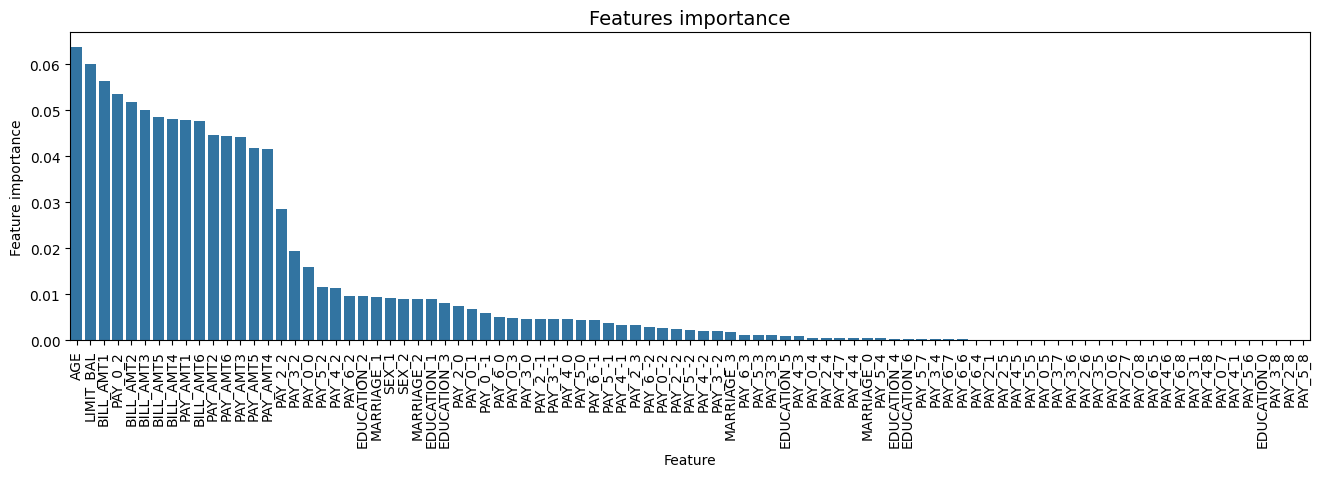

In [135]:
tmp = pd.DataFrame({'Feature': predictors_f, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (16,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

The most important features are **AGE**, **LIMIT_BAL**, **BILL_AMT1**, **PAY_0_2**, **BILL_AMT2**, **BILL_AMT3**.

#### Confusion matrix

Let's show a confusion matrix for the results we obtained.

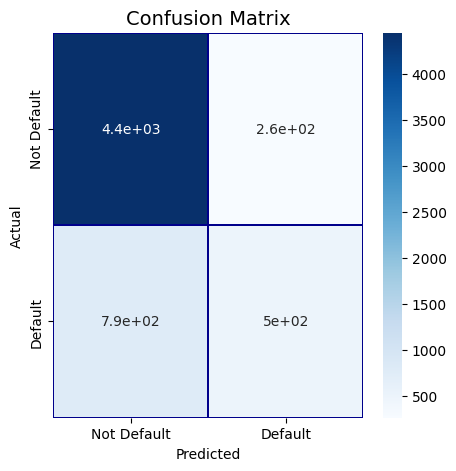

In [136]:
cm = pd.crosstab(val_fa_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Not Default', 'Default'],
            yticklabels=['Not Default', 'Default'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

We also calculate area under curve (receiver operator characteristic)

In [137]:
roc_auc_score(val_fa_df[target].values, preds)

0.6667660736878931

With the dummified features, the improvement of the AUC score is quite small.

## <a id="62">AdaBoostClassifier</a>


AdaBoostClassifier stands for Adaptive Boosting Classifier <a href='#8'>[5]</a>.

### Prepare the model

Let's set the parameters for the model and initialize the model.

In [150]:
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

### Fit the model

Let's fit the model.

In [151]:
clf.fit(train_df[predictors], train_df[target].values)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoostClassifier(algorithm='SAMME', learning_rate=0.8, n_estimators=100,
                   random_state=2018)

### Predict the target values

Let's now predict the **target** values for the **val_df** data, using predict function.

In [152]:
preds = clf.predict(val_df[predictors])

### Features importance

Let's see also the features importance.

<ipython-input-153-34030293d53b>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


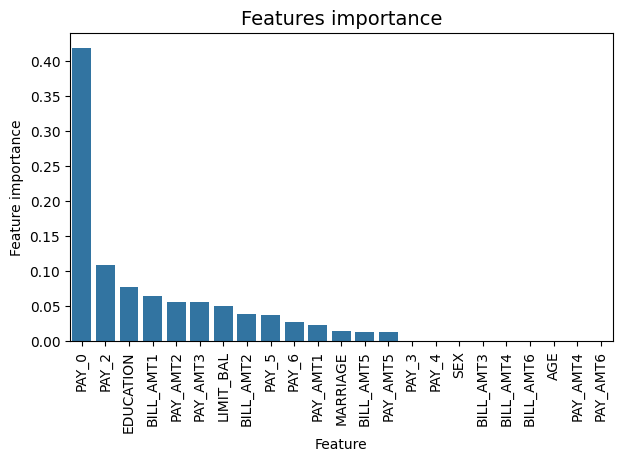

In [153]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

###Confusion Matrix
Let's visualize the confusion matrix

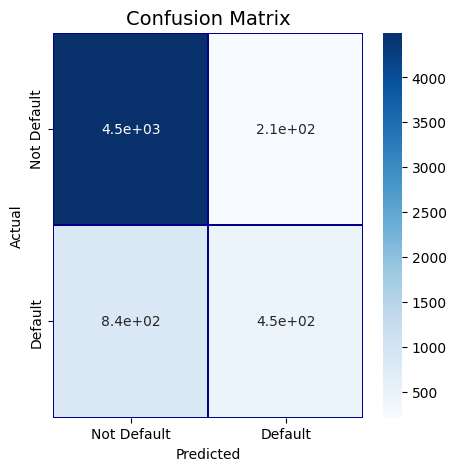

In [168]:
cm = pd.crosstab(val_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Not Default', 'Default'],
            yticklabels=['Not Default', 'Default'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

We also calculate area under curve (receiver operator characteristic).

In [155]:
roc_auc_score(val_df[target].values, preds)

0.6315766457725602

The **ROC-AUC** score obtained with **RandomForrestClassifier** is **0.63**.


Let's use for RandomForrestClassifier **dummified variables** for the **categorical features**.


We start by defining the categorical features.


### RandomForrest with OneHotEncoder

In [157]:
cat_features = ['EDUCATION', 'SEX', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [158]:
train_f_df = pd.get_dummies(train_df_bkp, columns = cat_features)
val_f_df = pd.get_dummies(val_df_bkp, columns = cat_features)

In [159]:
print("Default of Credit Card Clients train data -  rows:",train_f_df.shape[0]," columns:", train_f_df.shape[1])
print("Default of Credit Card Clients val  data -  rows:",val_f_df.shape[0]," columns:", val_f_df.shape[1])

Default of Credit Card Clients train data -  rows: 24000  columns: 93
Default of Credit Card Clients val  data -  rows: 6000  columns: 86


Because train and validation data does not have the same number of columns, we will align them.

In [160]:
train_fa_df, val_fa_df = train_f_df.align(val_f_df, join='outer', axis=1, fill_value=0)

In [161]:
print("Default of Credit Card Clients train data -  rows:",train_fa_df.shape[0]," columns:", train_fa_df.shape[1])
print("Default of Credit Card Clients val  data -  rows:",val_fa_df.shape[0]," columns:", val_fa_df.shape[1])

Default of Credit Card Clients train data -  rows: 24000  columns: 93
Default of Credit Card Clients val  data -  rows: 6000  columns: 93


In [162]:
train_fa_df.head(5)

,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,ID,LIMIT_BAL,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-1,PAY_0_-2,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-1,PAY_2_-2,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-1,PAY_3_-2,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-1,PAY_4_-2,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-1,PAY_5_-2,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-1,PAY_6_-2,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,default.payment.next.month
22659,48,175095.0,175522.0,173918.0,174074.0,178671.0,178869.0,False,False,False,True,False,False,False,22660,150000.0,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,10011.0,6200.0,5874.0,10000.0,6054.0,7108.0,False,True,0
6618,37,8788.0,40927.0,28306.0,31578.0,21195.0,11776.0,False,False,True,False,False,False,False,6619,180000.0,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,40970.0,1210.0,10015.0,10009.0,11783.0,110306.0,True,False,0
26605,23,2400.0,2400.0,2400.0,2400.0,2400.0,1800.0,False,False,True,False,False,False,False,26606,20000.0,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,0.0,0.0,0.0,0.0,0.0,0.0,True,False,1
2504,30,440.0,30404.0,0.0,880.0,150.0,430.0,False,False,True,False,False,False,False,2505,180000.0,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,30404.0,0.0,880.0,150.0,430.0,747.0,True,False,0
1111,44,3424.0,155.0,1922.0,1473.0,1865.0,835.0,False,False,False,True,False,False,False,1112,50000.0,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,155.0,1922.0,1473.0,1865.0,835.0,1833.0,False,True,0


In [163]:
train_fa_df.head(5)

,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,ID,LIMIT_BAL,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-1,PAY_0_-2,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-1,PAY_2_-2,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-1,PAY_3_-2,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-1,PAY_4_-2,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-1,PAY_5_-2,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-1,PAY_6_-2,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,default.payment.next.month
22659,48,175095.0,175522.0,173918.0,174074.0,178671.0,178869.0,False,False,False,True,False,False,False,22660,150000.0,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,10011.0,6200.0,5874.0,10000.0,6054.0,7108.0,False,True,0
6618,37,8788.0,40927.0,28306.0,31578.0,21195.0,11776.0,False,False,True,False,False,False,False,6619,180000.0,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,40970.0,1210.0,10015.0,10009.0,11783.0,110306.0,True,False,0
26605,23,2400.0,2400.0,2400.0,2400.0,2400.0,1800.0,False,False,True,False,False,False,False,26606,20000.0,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,0.0,0.0,0.0,0.0,0.0,0.0,True,False,1
2504,30,440.0,30404.0,0.0,880.0,150.0,430.0,False,False,True,False,False,False,False,2505,180000.0,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,30404.0,0.0,880.0,150.0,430.0,747.0,True,False,0
1111,44,3424.0,155.0,1922.0,1473.0,1865.0,835.0,False,False,False,True,False,False,False,1112,50000.0,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,155.0,1922.0,1473.0,1865.0,835.0,1833.0,False,True,0


Let's define the target and predictors lists.

In [164]:
target_f = 'default.payment.next.month'
predictors_f = ['AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'EDUCATION_0', 'EDUCATION_1',
       'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'EDUCATION_5',
       'EDUCATION_6', 'LIMIT_BAL', 'MARRIAGE_0', 'MARRIAGE_1',
       'MARRIAGE_2', 'MARRIAGE_3', 'PAY_0_-1', 'PAY_0_-2', 'PAY_0_0',
       'PAY_0_1', 'PAY_0_2', 'PAY_0_3', 'PAY_0_4', 'PAY_0_5', 'PAY_0_6',
       'PAY_0_7', 'PAY_0_8', 'PAY_2_-1', 'PAY_2_-2', 'PAY_2_0', 'PAY_2_1',
       'PAY_2_2', 'PAY_2_3', 'PAY_2_4', 'PAY_2_5', 'PAY_2_6', 'PAY_2_7',
       'PAY_2_8', 'PAY_3_-1', 'PAY_3_-2', 'PAY_3_0', 'PAY_3_1', 'PAY_3_2',
       'PAY_3_3', 'PAY_3_4', 'PAY_3_5', 'PAY_3_6', 'PAY_3_7', 'PAY_3_8',
       'PAY_4_-1', 'PAY_4_-2', 'PAY_4_0', 'PAY_4_1', 'PAY_4_2', 'PAY_4_3',
       'PAY_4_4', 'PAY_4_5', 'PAY_4_6', 'PAY_4_7', 'PAY_4_8', 'PAY_5_-1',
       'PAY_5_-2', 'PAY_5_0', 'PAY_5_2', 'PAY_5_3', 'PAY_5_4', 'PAY_5_5',
       'PAY_5_6', 'PAY_5_7', 'PAY_5_8', 'PAY_6_-1', 'PAY_6_-2', 'PAY_6_0',
       'PAY_6_2', 'PAY_6_3', 'PAY_6_4', 'PAY_6_5', 'PAY_6_6', 'PAY_6_7',
       'PAY_6_8', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4',
       'PAY_AMT5', 'PAY_AMT6', 'SEX_1', 'SEX_2']

Let's train the **RandonForestClassifier** using the **train_fa_df** data and **fit** function.

In [165]:
clf.fit(train_fa_df[predictors_f], train_df[target_f].values)


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoostClassifier(algorithm='SAMME', learning_rate=0.8, n_estimators=100,
                   random_state=2018)

Let's now predict the **target** values for the **val_df** data, using **predict** function.

In [166]:
preds = clf.predict(val_fa_df[predictors_f])

Let's also visualize the features importance.

#### Features importance

<ipython-input-167-1a1dc3aa9f65>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


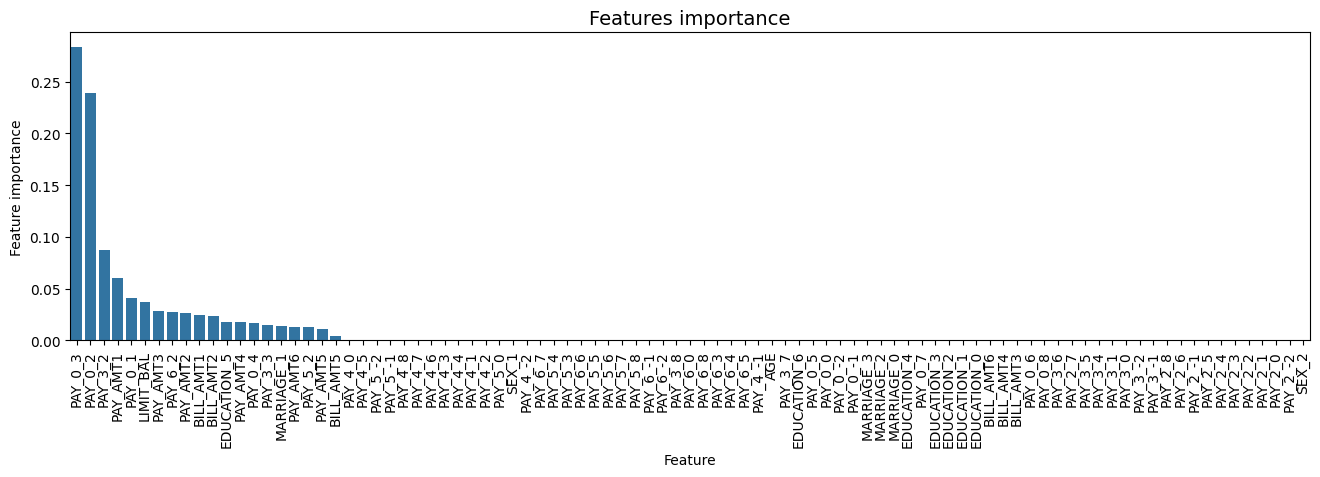

In [167]:
tmp = pd.DataFrame({'Feature': predictors_f, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (16,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

The most important features are **AGE**, **LIMIT_BAL**, **BILL_AMT1**, **PAY_0_2**, **BILL_AMT2**, **BILL_AMT3**.

#### Confusion matrix

Let's show a confusion matrix for the results we obtained.

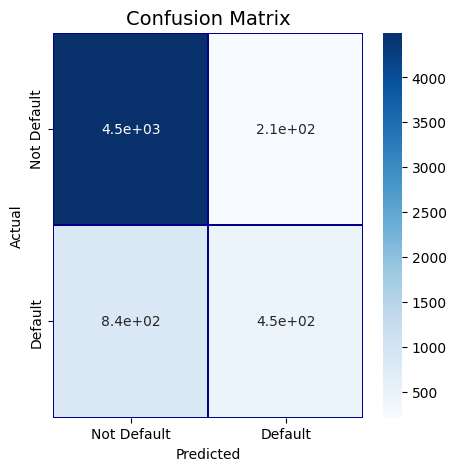

In [169]:
cm = pd.crosstab(val_fa_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Not Default', 'Default'],
            yticklabels=['Not Default', 'Default'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [170]:
roc_auc_score(val_df[target].values, preds)

0.6526201367279462

The ROC-AUC score obtained with AdaBoostClassifier is **0.65**

## <a id="63">CatBoostClassifier</a>


CatBoostClassifier is a gradient boosting for decision trees algorithm with support for handling categorical data <a href='#8'>[6]</a>.

### Prepare the model

Let's set the parameters for the model and initialize the model.

In [171]:
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [172]:
clf.fit(train_df[predictors], train_df[target].values,verbose=True)

0:	total: 279ms	remaining: 2m 19s
50:	total: 12.9s	remaining: 1m 53s
100:	total: 25.9s	remaining: 1m 42s
150:	total: 41.6s	remaining: 1m 36s
200:	total: 55.2s	remaining: 1m 22s
250:	total: 1m 8s	remaining: 1m 7s
300:	total: 1m 23s	remaining: 55s
350:	total: 1m 36s	remaining: 41s
400:	total: 1m 53s	remaining: 28s
450:	total: 2m 7s	remaining: 13.8s
499:	total: 2m 20s	remaining: 0us


### Predict the target values

Let's now predict the **target** values for the **val_df** data, using predict function.

In [203]:
preds = clf.predict(val_df[predictors])

###Feature Importance

<ipython-input-204-34030293d53b>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


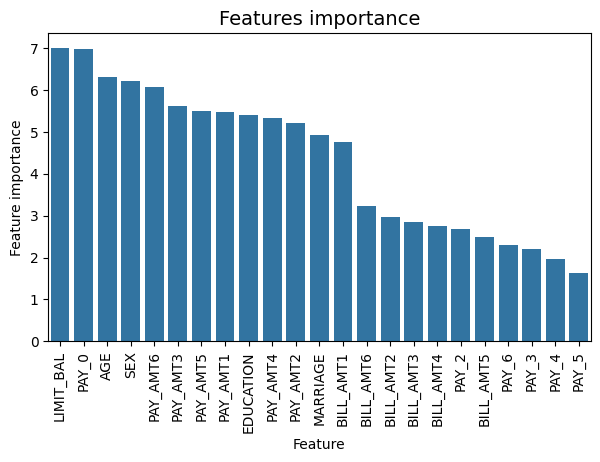

In [204]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

###Confusion Matrix

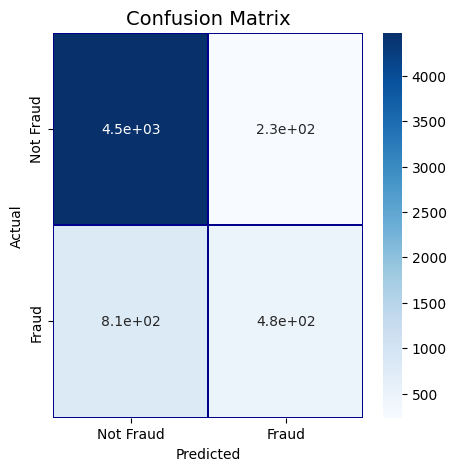

In [205]:
cm = pd.crosstab(val_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

###Area under the curve

In [206]:
roc_auc_score(val_df[target].values, preds)

0.6628421815446207

The ROC-AUC score obtained with CatBoostClassifier is **0.66**

#XGBOOST
XGBoost is a gradient boosting algorithm <a href='#8'>[7]</a>.

Let's prepare the model.

In [174]:
import xgboost as xgb

### Prepare the model

We initialize the DMatrix objects for training and validation, starting from the datasets. We also set some of the parameters used for the model tuning.

In [180]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(val_df[predictors], val_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

### Train the model

Let's train the model.

In [181]:
model = xgb.train(params,
                dtrain,
                MAX_ROUNDS,
                watchlist,
                early_stopping_rounds=EARLY_STOP,
                maximize=True,
                verbose_eval=VERBOSE_EVAL)

[0]	train-auc:0.69285	valid-auc:0.69768


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:23:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.76949	valid-auc:0.76622
[100]	train-auc:0.77715	valid-auc:0.77315
[150]	train-auc:0.78253	valid-auc:0.77700
[200]	train-auc:0.78580	valid-auc:0.77867
[250]	train-auc:0.78855	valid-auc:0.78041
[300]	train-auc:0.79068	valid-auc:0.78148
[350]	train-auc:0.79285	valid-auc:0.78262
[400]	train-auc:0.79459	valid-auc:0.78339
[450]	train-auc:0.79608	valid-auc:0.78370
[500]	train-auc:0.79759	valid-auc:0.78371
[550]	train-auc:0.79893	valid-auc:0.78413
[600]	train-auc:0.80029	valid-auc:0.78409
[633]	train-auc:0.80110	valid-auc:0.78414


The best validation score (ROC-AUC) was **0.78**.

##Plotting variable importance

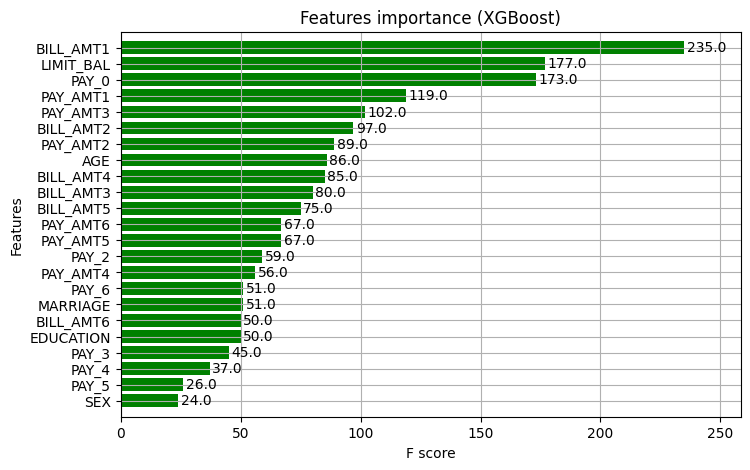

In [182]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green")
plt.show()

## <a id="65">LightGBM</a>


Let's continue with another gradient boosting algorithm, LightGBM <a href='#8'>[7]</a> <a href='#8'>[8]</a>.


### Define model parameters

Let's set the parameters for the model.

In [183]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':50, # because training data is sightly unbalanced
         }

###Prepare the model

Let's define teh categorical features.

In [184]:
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE','PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

Let's prepare the model, creating the **Dataset**s data structures from the train and validation sets.

We will also initialize the Datasets with the list of the categorical features (**lgb** has a special treatment for categorical values).

In [196]:
dtrain = lgb.Dataset(train_df[predictors].values,
                     label=train_df[target].values,
                     feature_name=predictors,
                     categorical_feature=categorical_features)

dvalid = lgb.Dataset(val_df[predictors].values,
                     label=val_df[target].values,
                     feature_name=predictors,
                     categorical_feature=categorical_features)


###Run the model
Let's run the model using **train** function

In [197]:
evals_results = {}

model = lgb.train(params,
                  dtrain,
                  valid_sets=[dtrain, dvalid],
                  valid_names=['train','valid'],
                  num_boost_round=MAX_ROUNDS,
                  feval=None,
                  callbacks=[lgb.early_stopping(stopping_rounds=EARLY_STOP),
                             lgb.record_evaluation(evals_results),
                             lgb.log_evaluation(VERBOSE_EVAL)])

del dvalid
gc.collect()

Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.778238	valid's auc: 0.771173
[100]	train's auc: 0.789346	valid's auc: 0.782605
[150]	train's auc: 0.794861	valid's auc: 0.784753
Early stopping, best iteration is:
[135]	train's auc: 0.793452	valid's auc: 0.785154


297

Best validation score was obtained for round 135 for which **AUC** **~= 0.78**

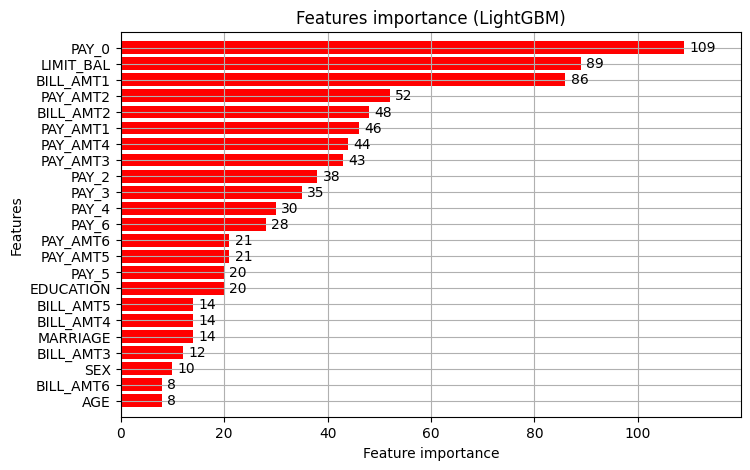

In [198]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Features importance (LightGBM)", ax=ax,color="red")
plt.show()

### Training and validation using cross-validation

Let's use now cross-validation. We will use cross-validation (KFolds) with 5 folds. Data is divided in 5 folds and, by rotation, we are training using 4 folds (n-1) and validate using the 5th (nth) fold.

In [202]:
kf = KFold(n_splits = NUMBER_KFOLDS, random_state = RANDOM_STATE, shuffle = True)
for train_index, test_index in kf.split(data_df):
    train_X, valid_X = data_df.iloc[train_index], data_df.iloc[test_index]

    dtrain = lgb.Dataset(train_X[predictors].values, label=train_X[target].values,
                     feature_name=predictors)

    dvalid = lgb.Dataset(valid_X[predictors].values, label=valid_X[target].values,
                     feature_name=predictors)

evals_results = {}

model = lgb.train(params,
                  dtrain,
                  valid_sets=[dtrain, dvalid],
                  valid_names=['train','valid'],
                  num_boost_round=MAX_ROUNDS,
                  feval=None,
                  callbacks=[lgb.early_stopping(stopping_rounds=EARLY_STOP),
                             lgb.record_evaluation(evals_results),
                             lgb.log_evaluation(VERBOSE_EVAL)])

Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.778941	valid's auc: 0.773321
[100]	train's auc: 0.788555	valid's auc: 0.780365
[150]	train's auc: 0.795057	valid's auc: 0.78276
[200]	train's auc: 0.7996	valid's auc: 0.783983
[250]	train's auc: 0.804012	valid's auc: 0.784121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	train's auc: 0.807877	valid's auc: 0.78461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[350]	train's auc: 0.811747	valid's auc: 0.784532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[321]	train's auc: 0.809658	valid's auc: 0.78483


The average validation **AUC** across the **5** folds is **0.78**, with values between **0.7733** (minimum) and **0.7841** (maximum)

We investigated the data, checking for data unbalancing, visualizing the features and understanding the relationship between different features.   

We then investigated five predictive models:  
* We started with **RandomForrestClassifier**, for which we obtained an AUC scode of **0.63**.
   For the **RandomForrestClassifier** we also experimented with **OneHotEncoder**, replacing the categorical features with dummified values (introducing one dummy variable for each category). The AUC score did not improved significantly in this case.
* Next we used  an **AdaBoostClassifier** model, with lower AUC score (**0.65**).   
* We followed with an **CatBoostClassifier** model, with lower AUC score (**0.66**).   
* Then we experimented with a **XGBoost** model, for which the AUC score obtained was **0.78**.   
* We then presented the data to a **LightGBM** model. We used both train-validation split and cross-validation to evaluate the model effectiveness to predict the target value, i.e. detecting if a credit card client  will default next month. With both methods for LightGBM the obtained values of AUC for the validation set were around **0.78**.